# Real-Time Drowsiness Detection

### importing all required libraries

In [325]:
import pickle
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import winsound

from pygame import mixer
from tkinter import *
from keras.layers import LeakyReLU
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


### extracting the dataset file from PC 

In [4]:
img_array = cv2.imread(r'C:\Users\APPLE\Desktop\EYES_DATASET\Close_Eyes\s0001_00001_0_0_0_0_0_01.png')

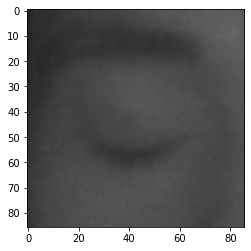

In [5]:
plt.imshow(img_array)

In [6]:
img_array.shape


(86, 86, 3)

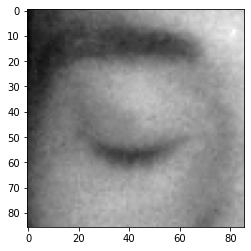

In [7]:
Datadirectory ="C:/Users/APPLE/Desktop/EYES_DATASET/"
Classes = ['Close_Eyes','Open_Eyes']
for category in Classes:
    path = os.path.join(Datadirectory,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
        plt.imshow(img_array,cmap="gray")
        plt.show()
        break
    break

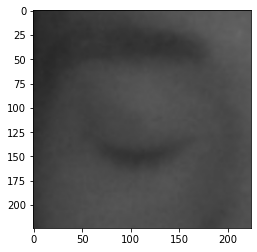

In [8]:
## resizing the image to 224 
img_size=224

new_array=cv2.resize(backtorgb,(img_size,img_size))
plt.imshow(new_array,cmap="gray")
plt.show()

In [9]:
new_array.shape

(224, 224, 3)

### Assinging the matix data of all the images to a list


In [10]:
training_Data =[]

def create_training_Data():
    for category in Classes:
        path = os.path.join(Datadirectory,category)
        class_num = Classes.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
                new_array = cv2.resize(backtorgb,(img_size,img_size))
                training_Data.append([new_array,class_num])
            except Exception as e:
                pass
                

In [11]:
create_training_Data()

In [12]:
print(len(training_Data))

39537


In [13]:
import random 

random.shuffle(training_Data)

In [14]:
X = []
y = []

for features,label in training_Data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1,img_size,img_size,3)

In [15]:
X.shape

(39537, 224, 224, 3)

### normalizing the X 

In [16]:
# have done this using standard scalar but due to large data issues had to do it manually
for i in range(0,39537):
    X[i]=X[i]/255.0

In [17]:
Y = np.array(y)

# Pickling the data 

In [18]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [19]:
# while opening again we can use this code no need to run the above code

pickle_in = open("X.pickle","wb")
X = pickle.load(pickle_in)

pickle_out = open("y.pickle","rb")
y = pickle.load(pickle_in)

UnsupportedOperation: read

## Transfer Learning Method starts from here

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

### Here we are using the mobilenet pretrained model  

In [21]:
model = tf.keras.applications.mobilenet.MobileNet()

In [22]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

### here we are deleting the bottom layer and attaching our model 

In [23]:
base_input = model.layers[0].input

In [24]:
base_output = model.layers[-4].output

### Before adding our model we I added couple of more layers inside it for more accuracy and used 'ELU' activation function rather than 'Relu' 

In [44]:
final_layer1=layers.Conv2D(1024,(1,1),activation='relu',input_shape=(224,224,3))(base_output)            # ---> "Conv2D" layer with activation function "relu"
final_layer2=layers.Conv2D(512,(1,1),activation='ELU')(final_layer1)                                     # ---> "Conv2D" layer with activation function "ELU"
final_layer3=layers.Dense(128)(final_layer2)                                                             # --->  Dense layer 
final_layer4=layers.Activation('ELU')(final_layer3)                                                      # ---> "ELU" activation layer


Flat_layer = layers.Flatten()(final_layer4)
final_output = layers.Dense(1)(Flat_layer)
final_oput = layers.Activation('sigmoid')(final_output)                                                 # --> as we are looking for 0/1 output in output layer we gave activation as sigmoid as we can give softmax 

In [45]:
new_model = keras.Model(inputs=base_input,outputs=final_oput)

In [46]:
new_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 512)      4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 512)      2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_9

### compiling & fitting the model 

In [47]:
# we used binary_crossentropy because we want the output to be 0/1 open/close

new_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [48]:
new_model.fit(X,Y,epochs=10,validation_split=0.1)

Epoch 1/10
1112/1112 [==============================] - 4616s 4s/step - loss: 0.3536 - accuracy: 0.7907 - val_loss: 0.0847 - val_accuracy: 0.9750
Epoch 2/10
1112/1112 [==============================] - 4734s 4s/step - loss: 0.3161 - accuracy: 0.8062 - val_loss: 0.0705 - val_accuracy: 0.9793
Epoch 3/10
1112/1112 [==============================] - 4651s 4s/step - loss: 0.3103 - accuracy: 0.8075 - val_loss: 0.0405 - val_accuracy: 0.9871
Epoch 4/10
1112/1112 [==============================] - 4640s 4s/step - loss: 0.3079 - accuracy: 0.8091 - val_loss: 0.0535 - val_accuracy: 0.9800
Epoch 5/10
1112/1112 [==============================] - 4637s 4s/step - loss: 0.3035 - accuracy: 0.8109 - val_loss: 0.0434 - val_accuracy: 0.9858
Epoch 6/10
1112/1112 [==============================] - 4905s 4s/step - loss: 0.3000 - accuracy: 0.8120 - val_loss: 0.0901 - val_accuracy: 0.9709
Epoch 7/10
1112/1112 [==============================] - 4709s 4s/step - loss: 0.2994 - accuracy: 0.8094 - val_loss: 0.0419 -

### above we got an accuracy of 81.5% and instad of running it every time we are saving the model

In [49]:
new_model.save('my_model.h5')

In [50]:
new_model = tf.keras.models.load_model('my_model.h5')

# OPEN EYES DETECTION 

#### below we are checking till which point in the array we get open eyes and from which point we get closed eyes will tell you the reason why we checked in coming steps 

In [159]:
img_array = cv2.imread(r"C:\Users\APPLE\Desktop\EYES_DATASET\Open_Eyes\s0032_01152_0_1_1_2_1_02.png",cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb,(img_size,img_size))

In [154]:
X_input = np.array(new_array).reshape(1,img_size,img_size,3)

In [155]:
X_input.shape

(1, 224, 224, 3)

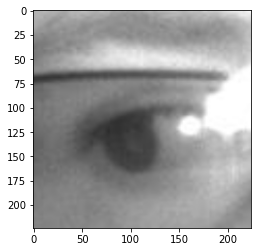

In [156]:
plt.imshow(new_array)

In [157]:
prediction = new_model.predict(X_input)

### after checking for couple of images I observed that open eyes are mostly above 0.5 

In [158]:
prediction

array([[0.9995383]], dtype=float32)

# CLOSE EYES DETECTION 

### same like above we are checking for the range of closed eyes

In [147]:
img_array = cv2.imread(r"C:\Users\APPLE\Desktop\EYES_DATASET\Close_Eyes\s0001_00939_0_1_0_2_0_01.png",cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb,(img_size,img_size))

In [148]:
X_input = np.array(new_array).reshape(1,img_size,img_size,3)

In [149]:
X_input.shape

(1, 224, 224, 3)

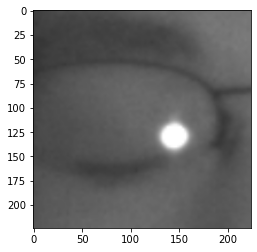

In [150]:
plt.imshow(new_array)

In [151]:
prediction = new_model.predict(X_input)

### most of the closed eyes range belove 0.5

In [152]:
prediction

array([[4.516489e-10]], dtype=float32)

# CHECKING FOR RANDOM IMAGES

In [299]:
img = cv2.imread(r"C:\Users\APPLE\Desktop\random_image.jpg")

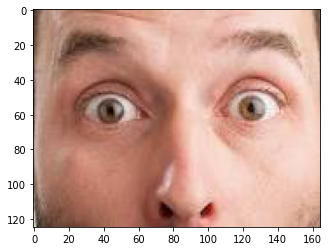

In [300]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [301]:
faceCascade = cv2.CascadeClassifier(r"C:\Users\APPLE\Desktop\haarcascade_frontalface_default.xml")

In [302]:
eyeCascade = cv2.CascadeClassifier(r"C:\Users\APPLE\Desktop\haarcascade_eye.xml")

In [303]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [304]:
eyes = eyeCascade.detectMultiScale(gray,1.1,4)

In [305]:
for(x,y,w,h) in eyes:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

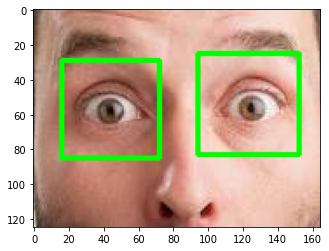

In [306]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [307]:
eyeCascade = cv2.CascadeClassifier(r"C:\Users\APPLE\Desktop\haarcascade_eye.xml")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
eyes = eyeCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in eyes:
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h,x:x+w]
    eyess = eyeCascade.detectMultiScale(roi_gray)
    if(len(eyess)==0):
        print("eyes are not found")
    else:
        for (ex,ey,ew,eh) in eyess:
            eyes_roi = roi_color[ey:ey+eh,ex:ex+ew]
            

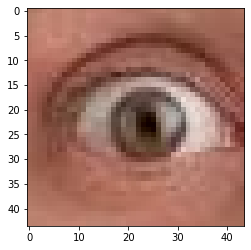

In [308]:
plt.imshow(cv2.cvtColor(eyes_roi,cv2.COLOR_BGR2RGB))

In [309]:
eyes_roi.shape

(44, 44, 3)

In [310]:
final_image = cv2.resize(eyes_roi,(224,224))
final_image = np.expand_dims(final_image,axis=0)
final_image = final_image/255.0

In [311]:
final_image.shape

(1, 224, 224, 3)

In [312]:
new_model.predict(final_image)

array([[0.5126674]], dtype=float32)

### Here we are doing all the things we have done above but using Real-Time means accesing the camera of laptop 

In [339]:
import cv2
mixer.init()
sound = mixer.Sound(r"C:\Users\APPLE\Downloads\mainJobservice\main\res\raw\alarm.mp3")
score = 0
path = r"C:\Users\APPLE\Desktop\haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(r"C:\Users\APPLE\Desktop\haarcascade_frontalface_default.xml")

cap = cv2.VideoCapture(1)

if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")
    
while True:
    ret,frame = cap.read()
    eyeCascade = cv2.CascadeClassifier(r"C:\Users\APPLE\Desktop\haarcascade_eye.xml")
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    eyes = eyeCascade.detectMultiScale(gray,1.2,3)
    height,width = frame.shape[0:2]
    for x,y,w,h in eyes:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = frame[y:y+h,x:x+w]
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
        eyess = eyeCascade.detectMultiScale(roi_gray)
        if(len(eyess)==0):
            print("eyes are not found")
        else:
            for (ex,ey,ew,eh) in eyess:
                eyes_roi = roi_color[ey:ey+eh,ex:ex+ew]
                
                
            final_image = cv2.resize(eyes_roi,(224,224))
            final_image = np.expand_dims(final_image,axis=0)
            Predictions = new_model.predict(final_image)
            print(Predictions)
    if (Predictions>0.5):
        #status = "OPEN Eyes"
        cv2.putText(frame,'Open',(10,height-20),fontFace=cv2.FONT_HERSHEY_COMPLEX,fontScale=1,color=(255,255,255),thickness=1)
        cv2.putText(frame,'score'+str(score),(100,height-20),fontFace=cv2.FONT_HERSHEY_COMPLEX,fontScale=1,color=(255,255,255),thickness=1)
        score=score-1
        if(score<0):
            score=0
        if(score<=8):
            try:
                sound.stop()
            except:
                pass
        
    else:
        #status = "CLOSE Eyes"  
        cv2.putText(frame,'Close',(10,height-20),fontFace=cv2.FONT_HERSHEY_COMPLEX,fontScale=1,color=(255,255,255),thickness=1)
        cv2.putText(frame,'score'+str(score),(100,height-20),fontFace=cv2.FONT_HERSHEY_COMPLEX,fontScale=1,color=(255,255,255),thickness=1)
        score=score+1
        if score>8 :
            try:
                sound.play()
            except:
                pass
        

    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    print(faceCascade.empty())
    faces = faceCascade.detectMultiScale(gray,1.2,3)
    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
    #font = cv2.FONT_HERSHEY_COMPLEX
    
    #cv2.putText(frame,status,(50,50),font,3,(0,0,255),2,cv2.LINE_4)
    cv2.imshow('Drowsiness Detection',frame)
    
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

[[0.9999699]]
[[0.9995229]]
False
[[0.9999599]]
[[0.99965566]]
False
[[0.9997031]]
[[0.9998831]]
False
[[0.9998515]]
[[0.999961]]
False
[[0.99996334]]
[[0.9996666]]
False
[[0.8610512]]
False
eyes are not found
eyes are not found
eyes are not found
False
[[0.5384821]]
eyes are not found
False
eyes are not found
False
[[0.72803986]]
False
[[0.19127971]]
False
eyes are not found
eyes are not found
False
[[0.78652227]]
False
eyes are not found
[[6.769642e-07]]
False
False
[[0.08908051]]
eyes are not found
False
eyes are not found
[[0.03554317]]
False
eyes are not found
False
[[0.8648578]]
False
eyes are not found
[[0.00027889]]
False
[[0.99987257]]
[[0.9994882]]
False
[[0.9997307]]
[[0.9998218]]
False
[[0.99857867]]
[[0.99944186]]
False
[[0.9839459]]
[[0.9902028]]
False
False
False
[[0.8364111]]
False
eyes are not found
False
[[0.9941511]]
[[0.99997395]]
False
[[0.43789363]]
[[0.9999713]]
False
[[0.98712134]]
[[0.9758657]]
False
[[0.9999008]]
[[0.99995637]]
False
[[0.0608272]]
eyes are not

[[0.99939]]
[[0.9999635]]
False
[[0.25337526]]
False
eyes are not found
False
[[0.00871316]]
False
eyes are not found
eyes are not found
False
[[0.00214827]]
False
[[0.34883535]]
False
[[0.5008288]]
False
[[0.00092393]]
False
[[0.568046]]
eyes are not found
False
[[0.939204]]
False
[[0.04168308]]
False
eyes are not found
False
[[0.00017142]]
False
[[0.00191668]]
eyes are not found
False
eyes are not found
False
[[0.00673443]]
[[2.8394554e-06]]
False
[[0.8749052]]
[[0.99992466]]
False
[[0.99989355]]
[[0.99993813]]
False
[[0.9994339]]
[[0.99967086]]
False
[[0.9987335]]
[[0.9999473]]
False
[[0.9984584]]
[[0.9999552]]
False
[[0.99992687]]
[[0.99973035]]
False
[[0.9999454]]
[[0.9936681]]
False
[[0.9999914]]
[[0.9999716]]
False
[[0.99997175]]
[[0.99996805]]
False
[[0.99996436]]
[[0.99992263]]
False
[[0.96139264]]
[[0.99996674]]
False
[[0.41720453]]
False
[[0.36841145]]
False
[[0.00573137]]
False
[[0.82193327]]
eyes are not found
False
[[0.96508384]]
False
[[0.9727367]]
False
[[0.829759]]
Fal